In [1]:
# !pip install uxsim
# !pip install networkx

In [2]:
from network_related_3 import make_distance_matrix, add_world_links, get_traffic_distribution_2
from uxsim import *
import random
import networkx as nx
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
SEED = 42
random.seed(SEED)

c:\Users\neevp\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class World2Graph:
    def _reset_graph(self):
        self.g = nx.DiGraph(name=self.name)
        return
    
    def _add_nodes_from_world(self):
        self.g.add_nodes_from(self.w.NODES)
        return
    
    def __init__(self, w:World, name="Test Graph"):
        self.w = w
        self.name = name

        self._reset_graph()
        self._add_nodes_from_world()
        self._add_edges_from_world()

        self._global_density = 0
        return
    
    def _add_edges_from_world(self):
        gdensity = 0
        for link in self.w.LINKS:            
            # Link Attributes
            norm_speed      = link.speed / link.free_flow_speed
            norm_density    = link.density / link.jam_density
            num_vehicles    = link.num_vehicles
            flow            = link.flow
            length          = link.length
            name            = link.name

            orig            = link.start_node
            dest            = link.end_node

            gdensity += link.density
            
            self.g.add_edge(orig, dest, length=length, speed=link.speed, norm_speed=norm_speed, flow=flow,
                            norm_density=norm_density, num_vehicles=num_vehicles)
            
        self._global_density = gdensity / len(self.w.LINKS)
        return
    
    def refresh(self):
        self._reset_graph()
        self._add_edges_from_world()
        return self.g
    
    def global_density(self):
        return self._global_density

class Estimator1:
    def __init__(self, w: World):
        self.translator = World2Graph(w, w.name)
        return
    
    def _combine_parameters(self, tgt_param="weight"):
        g = self.translator.refresh()
        for u, v, data in g.edges(data=True):
            data[tgt_param] = data["length"] / data["speed"]
        self.g = g
        return g
    
    # This function is given in order to optimize in the future. Basically the graph 
    # is being refreshed for every car every loop
    # In the future call refresh and then call eta()   
    def refresh(self):
        self.g = self._combine_parameters()
        return
    
    def eta_with_refresh(self, src, dest):
        g = self._combine_parameters()
        shortest_path = nx.dijkstra_path(g, src, dest, weight='weight')
        eta = nx.dijkstra_path_length(g, src, dest, weight='weight')
        return eta, shortest_path
    
class Estimator2:
    def __init__(self, w: World):
        self.translator = World2Graph(w, w.name)
        self.prev_paths = None
        self.counter = 0
        return
    
    def _combine_parameters(self, tgt_param="weight"):
        g = self.translator.refresh()
        for u, v, data in g.edges(data=True):
            data[tgt_param] = data["length"] / data["speed"]
        self.g = g
        return g
    
    # This function is given in order to optimize in the future. Basically the graph 
    # is being refreshed for every car every loop
    # In the future call refresh and then call eta()   
    def refresh(self):
        self.g = self._combine_parameters()
        return
    
    def eta_with_refresh(self, src, dest, vehicle_length=3.9):
        # Throws nx.NetworkXNoPath
        g = self._combine_parameters()

        # Testing
        glob_dens = self.translator.global_density()
        vehicle_length = ((6 - 0)/(0.06 - 0)) * glob_dens
        # Testing

        # Optimization 1
        if self.counter % 100 == 0:
            all_paths = list(nx.all_simple_paths(
                self.g, source=src, target=dest))
            self.prev_paths = all_paths
        else:
            all_paths = self.prev_paths
        self.counter += 1
        
        # Optim 1
        
        if not all_paths:
            print("No paths found!", src, dest)
            print(list(nx.all_simple_paths(self.g, source=src, target=dest)))
            raise nx.NetworkXNoPath()
        
        min_real_time_distance = float('inf')
        min_eta_path = None
        eta = None  # Base travel time

        for path in all_paths:
            di = 0  # Base travel time
            tewi = 0  # Total estimated weight of vehicles
            
            # Loop through edges in the path
            for u, v in zip(path[:-1], path[1:]):
                edge_data = g.get_edge_data(u, v)

                di += edge_data.get('weight', 0)  # Sum of travel times
                tewi += edge_data.get('num_vehicles', 0)  # Sum of vehicles

            # Compute real-time adjusted distance
            real_time_distance = di + (tewi * vehicle_length)

            # Track the best path
            if real_time_distance < min_real_time_distance:
                min_real_time_distance = real_time_distance
                min_eta_path = path
                eta = di  # Store base travel time
                
        return min_real_time_distance, min_eta_path

In [4]:
class Vehicle_Handler1:
    def __init__(self, w:World, srcs: list, dests: list, hour_res, k=50):
        self.max_time = hour_res*24

        self.w = w
        self.srcs =  srcs
        self.dests = dests
        self.k = k
        
        self.estimators = []
        self.log = []
        return
    
    def add_testing_vehicles(self):
        self.added_cars = {}
        for i in range(self.k):
            
            src  =  random.choice(self.srcs)
            dest = random.choice(self.dests)
            while src == dest:
                src  =  random.choice(self.srcs)
                dest = random.choice(self.dests)
                
            start_time = random.randint(0,int(0.55 * self.max_time))
            name = f"{src}_{dest}_{start_time}"

            veh = self.w.addVehicle(src, dest, start_time, name)
            self.added_cars[name] = veh

        self.added_car_header = list(self.added_cars.keys())
        return
    
    def init_estimator(self, Estimator):
        self.estimator = Estimator(self.w)

    def log_vehical_data(self):
        row = [self.w.TIME]

        for name in self.added_car_header:
            # Get car info 
            car = self.added_cars[name]
            
            # If link is None, car is not in world
            if car.link is None:
                row.append(None)
                continue

            # Find nearest node
            coords = car.get_xy_coords()
            nearest_node = self.w.get_nearest_node(*coords)

            # Find ETA and append it
            src  = nearest_node
            dest = car.dest
            
            if src == dest:
                continue

            try:
                eta, min_path = self.estimator.eta_with_refresh(src, dest)
                row.append(eta)
            except nx.NetworkXNoPath as NoPathException:
                raise Exception()


        self.log.append(row)
        return

    def get_processed_df_1(self):
        df = pd.DataFrame(self.log, columns=["timestamp"] + list(self.added_car_header))
        df.set_index("timestamp", inplace=True)

        # Remove all rows which are null and inf
        df.replace(np.inf, np.nan, inplace=True)
        df = df[~df.isnull().all(axis=1)]

        return df
    
    def get_processed_df_2(self):
        # Return the first five not null per column
        df = self.get_processed_df_1()
        df = df.apply(lambda col: col.dropna().head(4))        
        return df
    
    def get_processed_df_3(self):
        df = self.get_processed_df_2().mean(axis=0).dropna(axis=0)
        return df
    
    def get_processed_df(self):
        return self.get_processed_df_3()

In [5]:
class Nadav_Simulation_2:
    def __init__(self, 
                nodes, signal_nodes_dic, node_locations, 
                normal_links, signal_links, signal_groups, link_ffs,
        ):
        # Store world nodes and signal_nodes
        self.nodes = nodes
        self.signal_nodes_dic = signal_nodes_dic

        # Store world links as also signal_links
        self.signal_links = signal_links
        self.links = normal_links + signal_links
        
        # Zip together if needed: node_name -> coordinates
        if type(node_locations) == list:
            self.coordinates = dict(zip(nodes, node_locations))
        else:
            self.coordinates = node_locations

        # Make edge lengths matrix (road lengths)
        self.edge_lengths = make_distance_matrix(
                            self.links, self.coordinates)

        # Make the dict structure: signal_link_name -> group
        if type(signal_groups) == list:
            self.signal_groups = dict(zip(signal_links, signal_groups))
        else:
            self.signal_groups = signal_groups
        
        # Make the dict structure: link_name -> speed limit
        if type(link_ffs) == list:
            self.link_ffs = dict(zip(self.links, link_ffs))
        else:
            self.link_ffs = link_ffs

        #  Edge Importance Matrix (Future Feature)
        self.edge_importance_dict = None
        return

    def init_world(self, sim_name="Network 3", tstep=5, hour_res=100, 
                   add_signals=True):
        # How many seconds represent an hour in the simulation
        self.hour_res = hour_res
        self.w = World(name=sim_name, tmax=24*hour_res, deltan=tstep,
                user_function=self.simulation_func, random_seed=SEED)
        
        self._init_world_nodes(add_signals=add_signals)
        self._init_world_edges()

        return
    
    def simulation_func(self, w:World):
        self.handler.log_vehical_data()
        return

    def _init_world_nodes(self, add_signals=True):
        for node in self.nodes:
            coor = self.coordinates[node]

            # If the node has a signal, add it separately, correctly
            if (node in self.signal_nodes_dic) and add_signals:
                self.w.addNode(node, coor[0], coor[1], 
                        signal=self.signal_nodes_dic[node])
            else:
                self.w.addNode(node, coor[0], coor[1])
        return
    
    def _init_world_edges(self):
        self.w, self.uplinks, self.downlinks = add_world_links(
                                self.w, self.links, self.link_ffs, 
                                self.edge_lengths, self.signal_links, 
                                self.signal_groups
        )
        return
    
    def add_general_demand_to_world(self, sources, destinations,
                                    time_intervals=2000, pairs=20):
        hours , probs = get_traffic_distribution_2()
        times_chosen = random.choices(hours, probs, k=time_intervals)

        # Choose random (pairs, destinations) -> they will be the routes
        chosen_srcs =  random.choices(sources, k=pairs)
        chosen_dests = random.choices(destinations, k=pairs)
        
        # At different time intervals different journeys will be chosen

        for i,t in enumerate(times_chosen):
            start = t   *  self.hour_res
            end =  (t+1) * self.hour_res
            jsrc, jdest = chosen_srcs[i % pairs] , chosen_dests[i % pairs]

            self.w.adddemand(jsrc, jdest, start, end, flow=0.05)

        return
    
    def add_testing_vehicles(self, srcs, dests, est, k=50):
        self.handler = Vehicle_Handler1(self.w, srcs, dests, 
                                        self.hour_res, k)
        self.handler.add_testing_vehicles()
        self.handler.init_estimator(est)
        return
    
    def simulate_1(self):
        print("Started Simulation-----")
        self.w.exec_simulation()
        return self.handler.get_processed_df()
    
    def save_simulation_graphic(self):
        # self.w.analyzer.network_fancy(animation_speed_inverse=50, figsize=10,
        #                               trace_length=2, sample_ratio=0.6)
        self.w.analyzer.network_anim(animation_speed_inverse=50, figsize=10,
                                     timestep_skip=5)
        return
    
    def save_simulation_image(self):
        self.w.analyzer.network_average()
        return
    
    def get_actual_timings(self):
        actual_data = self.w.analyzer.vehicles_to_pandas()
        cars_in_question = self.handler.added_car_header

        filtered_df = actual_data[actual_data["name"].isin(cars_in_question)]

        # Aggregate by 'Name' and get min & max timestamp
        aggregated_df = filtered_df.groupby("name").agg(
            min_time=("t", "min"),
            max_time=("t", "max")
        ).reset_index()
        aggregated_df.set_index("name", inplace=True)

        aggregated_df["delta"] = aggregated_df["max_time"] - aggregated_df["min_time"]
        
        return aggregated_df, aggregated_df["delta"].to_dict()

In [6]:
from area_1 import *
# from sioux_area import *
sim = Nadav_Simulation_2(world_nodes, signal_node_group_dic, translated_node_coord_dic, 
                         world_links, signal_links, signal_link_group_dic, all_links_ff_dic)
sim.init_world(add_signals=True)
sim.add_general_demand_to_world(testing_sources, testing_sinks,
                                pairs=25, time_intervals=3000)
sim.add_testing_vehicles(testing_personal_srcs, testing_personal_dests,
                         est=Estimator2, k=60)

# Medium time_intervals is 2000, and heavy is 6000

estimates_df = sim.simulate_1()
# sim.save_simulation_graphic()



Started Simulation-----
simulation setting:
 scenario name: Network 3
 simulation duration:	 2400 s
 number of vehicles:	 15300 veh
 total road length:	 29384.7 m
 time discret. width:	 5 s
 platoon size:		 5 veh
 number of timesteps:	 480
 number of platoons:	 3060
 number of links:	 60
 number of nodes:	 27
 setup time:		 0.34 s
simulating...
      time| # of vehicles| ave speed| computation time
       0 s|        0 vehs|   0.0 m/s|     0.00 s


     600 s|      480 vehs|   8.7 m/s|     0.81 s
    1200 s|      750 vehs|   5.6 m/s|     1.81 s
    1800 s|      785 vehs|   4.7 m/s|     2.79 s
    2395 s|      775 vehs|   5.4 m/s|     3.52 s
 simulation finished


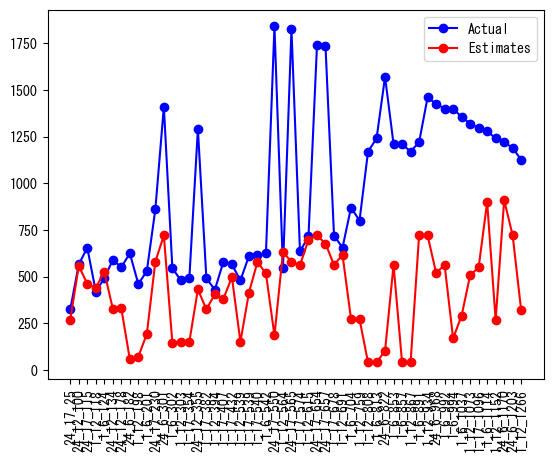

(np.float64(539.0794577761113), np.float64(533.8184913387496))


In [ ]:
estimates_dict = estimates_df.to_dict()
# estimates_df.to_csv("Area_1/Outputs_Est_2_Sig/Estimates.csv")
# estimates_df.to_csv("Area_1/Outputs_Est_2_NoSig/Estimates.csv")

# df2 = sim.handler.get_processed_df_1()
# df2.to_csv("Outputs_E2_NS/raw_time_estimates.csv")

actual_df , actual_timings_dic = sim.get_actual_timings()
# actual_df.to_csv("Area_1/Outputs_Est_2_Sig/Actual_Timings.csv")
# actual_df.to_csv("Area_1/Outputs_Est_2_NoSig/Actual_Timings.csv")

def graph_comparison(estimates, actual):
    names = list(estimates.keys())
    names = sorted(names, key=lambda s: int(s.split('_')[2]))

    y, yhat = [], []
    for car in names:
        yhat.append(estimates[car])
        y.append(actual[car])
    return names, y, yhat

def error_analysis(names, y, yhat):
    y    = np.array(y)
    yhat = np.array(yhat)

    error         = y - yhat
    avg_error     = error.mean()
    avg_abs_error = np.abs(error).mean()

    return avg_abs_error, avg_error

names, y, yhat = graph_comparison(estimates_dict, actual_timings_dic)
plt.plot(names, y,         linestyle="-", marker="o", c="blue")
plt.plot(names, yhat,      linestyle="-", marker="o", c="red")
plt.xticks(rotation=90)
plt.legend(['Actual','Estimates'])
plt.show()


print(error_analysis(names, y, yhat))